In [36]:
## Setting up the mediawiki client for the categories
import mwclient
site = mwclient.Site('en.wikipedia.org')

import bz2
import json
import ijson
import requests
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from collections import Counter

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# sns.color_palette("Blues")

from tqdm import tqdm
tqdm.pandas()

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
sns.set_style('whitegrid')
# sns.set_context("paper")

In [3]:
## Removing all main sites which have aggregated data
citations_bias_features = pd.read_parquet('citations_bias_features.parquet/', engine='pyarrow')
citations_bias_features = citations_bias_features[~citations_bias_features['tld'].isin(
    ['google', 'facebook', 'youtube', 'imdb', 'amazon', 'go'])]

In [4]:
print('Total number of citations with some sort of score: {}'.format(citations_bias_features.shape[0]))

Total number of citations with some sort of score: 5678515


In [5]:
citations_bias_features.head()

,URL,tld,citations,Title,sub_domain,sections,type_of_citation,ID_list,id,r_id,r_parentid,page_title,page_id,ref_index,total_words,neighboring_words,neighboring_tags,bias_score,sub_dom,has_subdom
0,http://news.bbc.co.uk/2/hi/africa/8304282.stm,bbc,{{cite news|title=Congo and Angola 'end expuls...,Congo and Angola 'end expulsions',news,Initial Section,cite news,None,710,950413903,950313138.0,Foreign relations of Angola,710,2259,12705,"[tit-for-tat, '', ref, name=, '', Bearak, '', ...","[JJ, '', NN, NN, '', NNP, '', NN, NN, NNP, NN,...",-0.6358,news,yes
1,https://timesofindia.indiatimes.com/entertainm...,indiatimes,{{Cite web|url=https://timesofindia.indiatimes...,Filmfare Awards Winners 1974: Complete list of...,timesofindia,Initial Section,cite web,None,1828,951787334,951509258.0,Amitabh Bachchan,1828,4261,23481,"[and, scripted, by, Biresh, Chatterjee, addres...","[CC, VBN, IN, NNP, NNP, VBG, NNS, IN, NN, ., P...",-0.9030,timesofindia,yes
2,https://timesofindia.indiatimes.com/entertainm...,indiatimes,{{Cite web|url=https://timesofindia.indiatimes...,Filmfare Awards Winners 1974: Complete list of...,timesofindia,Initial Section,cite web,None,1828,951787334,951509258.0,Amitabh Bachchan,1828,4261,23481,"[and, scripted, by, Biresh, Chatterjee, addres...","[CC, VBN, IN, NNP, NNP, VBG, NNS, IN, NN, ., P...",-0.9446,timesofindia,yes
3,https://www.theguardian.com/music/2015/feb/22/...,theguardian,{{Cite news |url=https://www.theguardian.com/m...,Public Service Broadcasting: The Race for Spac...,music,In popular culture,cite news,None,1965,953308828,952520940.0,Apollo 1,1965,15906,16507,"[the, Public, Service, Broadcasting, band, Pub...","[DT, NNP, NNP, NNP, NNP, NNP, NNP, NNP, NN, NN...",-1.3503,music,yes
4,http://www.thecanadianencyclopedia.com/en/arti...,thecanadianencyclopedia,{{cite encyclopedia |title=College Songs and S...,College Songs and Songbooks,en,Initial Section,cite encyclopedia,None,2236,944933372,942207829.0,Acadia University,2236,3555,5554,"[University, fight, song, ., According, to, 'S...","[NNP, NN, NN, ., VBG, TO, NNS, IN, NNP, NNP, N...",-0.6380,en,yes


### Get the count of the most important TLDs

In [6]:
top_tlds = citations_bias_features.groupby('tld').count().sort_values(
    'Title', ascending=False)['URL'][:30].reset_index()
top_tlds['Count'] = top_tlds['URL']
top_tlds.head(20)

,tld,URL,Count
0,bbc,517648,517648
1,mtv,476333,476333
2,billboard,173019,173019
3,rollingstone,145804,145804
4,indiatimes,114255,114255
5,abc,93946,93946
6,latimes,90192,90192
7,independent,84926,84926
8,telegraph,84172,84172
9,cnn,72708,72708


In [7]:
# import pylab as p

In [8]:
# params = { 
#     'figure.figsize': (12, 8), 'axes.labelsize': '35',  
#     'axes.titlesize': '35', 'xtick.labelsize': '35', 'ytick.labelsize': '35' ,
#     "lines.linewidth": 4
# } 
# p.rcParams.update(params)       


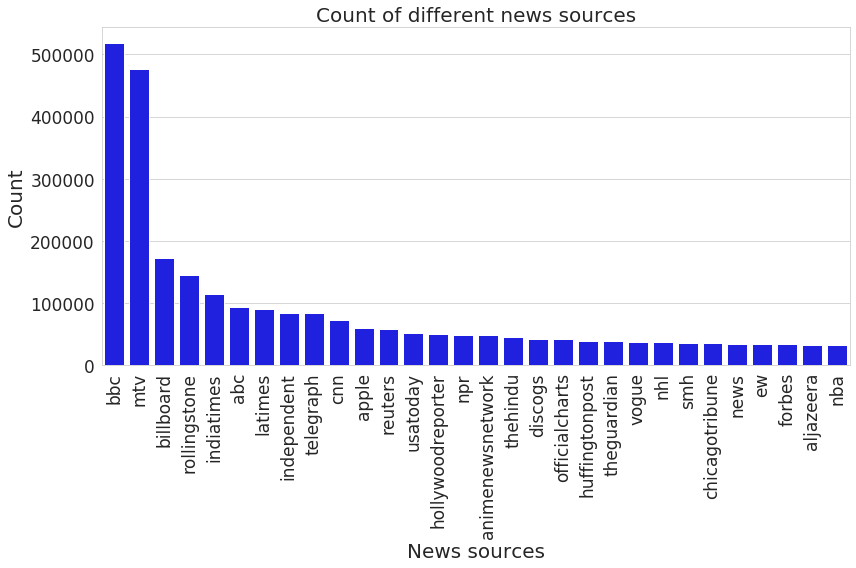

In [37]:
# plt.figure(figsize=(12,8))
# plt.ylabel('Count of citations', fontsize=20)
# ax = sns.barplot(x="tld", y="Count", data=top_tlds, color="#0000ff")
# ax.set_title('Count of different news sources', fontsize=20)
# plt.xlabel('News sources', fontsize=20)
# ax.tick_params(labelsize=17)
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.savefig('count_different_sources.png', dpi=300)

## plot the distribution of the bias score
# plt.figure(figsize=(12,8))
# plt.ylabel('Count of citations', fontsize=20)
ax = sns.distplot(citations_bias_features['bias_score'], kde=False, color="#0000ff")
ax.set_title('Citation with bias', fontsize=20)
plt.xlabel('Bias score', fontsize=20)
ax.tick_params(labelsize=17)
plt.tight_layout()
plt.savefig('distribution_of_score.png', dpi=300) 

In [10]:
print('Potentially conservative citations: {}'.format(
    citations_bias_features[citations_bias_features['bias_score'] > 0.5].shape[0]))

Potentially conservative citations: 157549


In [11]:
137789 / 5742457.0

0.023994781327922873

### Number of the soures which had joined subdomain and which had not

In [257]:
citations_bias_features[['Title', 'has_subdom']].groupby('has_subdom').count()

,Title
has_subdom,
no,4848334
yes,824210


Most of the cells are either in the range from `MODR` (from 0.5 to -0.5) or in the `LIBR` from (-0.5 to -2), with very less citations present as the ground truth for liberal

In [279]:
citations_bias_features[citations_bias_features['bias_score'] < -0.5].shape

(3442343, 20)

In [280]:
3442343 / 5742457

0.5994547281764583

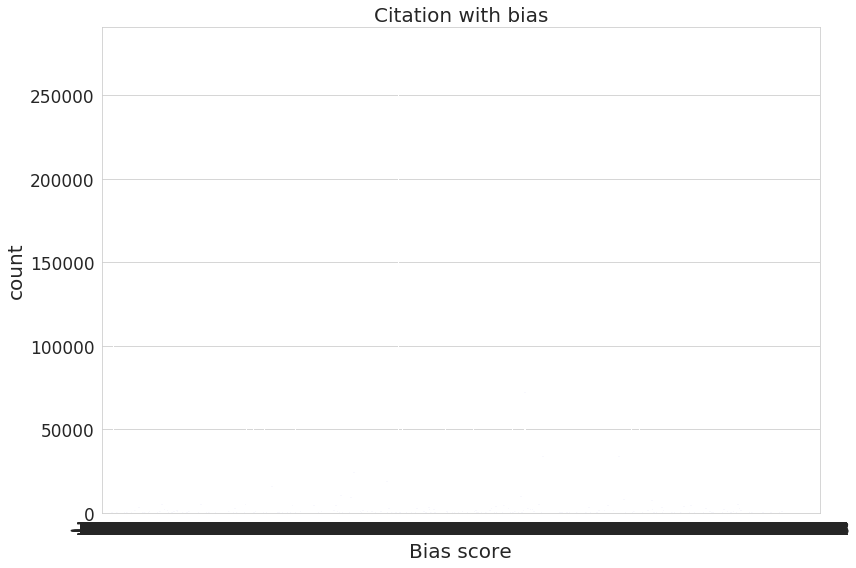

In [76]:
## plot the distribution of the bias score
plt.figure(figsize=(12,8))
plt.ylabel('Count of citations', fontsize=20)
ax = sns.countplot(citations_bias_features['bias_score'], color="blue")
ax.set_title('Citation with bias', fontsize=20)
plt.xlabel('Bias score', fontsize=20)
ax.tick_params(labelsize=17)
plt.tight_layout()
plt.savefig('distribution_of_score.png', dpi=300) 

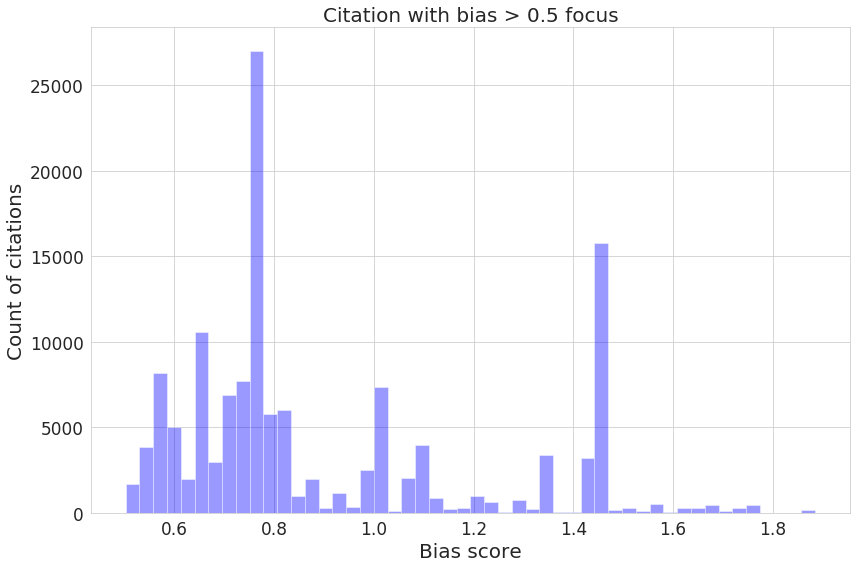

In [69]:
plt.figure(figsize=(12,8))
plt.ylabel('Count of citations', fontsize=20)
ax = sns.distplot(
    citations_bias_features[citations_bias_features['bias_score'] > 0.5]['bias_score'], kde=False, color="blue")
ax.set_title('Citation with bias > 0.5 focus', fontsize=20)
plt.xlabel('Bias score', fontsize=20)
ax.tick_params(labelsize=17)
plt.tight_layout()
plt.savefig('distribution_of_cons.png', dpi=300)

Number of conservative citations, this is only applied for all citations which have a bias score of more than 0.5

In [17]:
potential_cons_citations = citations_bias_features[citations_bias_features['bias_score'] > 0.5].shape[0]
print('Total number of possible conservative citations are: {}'.format(
    potential_cons_citations))
print('Percentage of citations: {}'.format((potential_cons_citations / citations_bias_features.shape[0]) * 100.0))

Total number of possible conservative citations are: 157549
Percentage of citations: 2.774475369000522


In [283]:
citations_bias_features[citations_bias_features['bias_score'] > 0.5].groupby(
    'tld').count().sort_values('Title', ascending=False)[:10]['URL']

tld
foxnews            16706
jpost               9510
standard            9019
timesofisrael       6876
al                  5943
motorsport          5700
tamu                5496
washingtontimes     5421
ynetnews            4500
fas                 4194
Name: URL, dtype: int64

In [284]:
## Looking at the spike of 0.75 and 0.78
mask = ((citations_bias_features['bias_score'] > 0.75) & (citations_bias_features['bias_score'] < 0.78))
citations_bias_features[mask].groupby('tld').count().sort_values('Title', ascending=False)[:10]['URL']

tld
jpost                9510
al                   5940
militarytimes        3571
tasteofcountry       2366
timesfreepress       1211
billingsgazette      1071
clarionledger         897
pga                   573
golfchannel           511
gwinnettdailypost     316
Name: URL, dtype: int64

In [285]:
## Looking at the spike after 1.4
citations_bias_features[citations_bias_features['bias_score'] > 1.4].groupby(
    'tld').count().sort_values('Title', ascending=False)[:10]['URL']

tld
foxnews                    14157
heritage                    2740
spectator                   2727
nationalreview              2263
townhall                     421
theamericanconservative      267
mrc                          238
lifenews                     235
shine                        154
americanthinker              151
Name: URL, dtype: int64

In [286]:
citations_bias_features[citations_bias_features['bias_score'] < -0.5].groupby(
    'tld').count().sort_values('Title', ascending=False)[:10]['URL']

tld
bbc                  515260
mtv                  439692
billboard            173019
indiatimes           114246
rollingstone         109353
latimes               90192
independent           84926
hollywoodreporter     49789
npr                   48817
animenewsnetwork      48470
Name: URL, dtype: int64

In [287]:
citations_bias_features[citations_bias_features['tld'].apply(lambda x: 'washington' in x)].groupby('tld').count()['URL']

tld
washingtoncaps             9
washingtoncitypaper     1270
washingtonjewishweek     108
washingtonpost          3823
washingtonspirit         297
washingtontimes         5421
Name: URL, dtype: int64

Doing a comparision between citations containing either Biden or Trump

Seems like the content for controversial pages is also might be made more.

In [288]:
## Citations with Joe Biden in the page title they are associated with
biden_citations = citations_bias_features[citations_bias_features['page_title'].progress_apply(
    lambda x: 'Joe Biden' in x)]
## Citations with Donald Trump in the page title they are associated with
donald_citations = citations_bias_features[citations_bias_features['page_title'].progress_apply(
    lambda x: 'Donald Trump' in x)]

print('Total number of citations associated with Biden: {}'.format(biden_citations.shape[0]))
print('Total number of citations associated with Trump: {}'.format(donald_citations.shape[0]))


100%|██████████| 5678515/5678515 [00:06<00:00, 940931.43it/s] 

100%|██████████| 5678515/5678515 [00:06<00:00, 925860.76it/s]

Total number of citations associated with Biden: 886
Total number of citations associated with Trump: 9510


Plot on the left is for the citations containing the word `Joe Biden` and on the right for `Donald Trump`, and as we can see both figures have more liberal sources cited than the conservative sources.

But also the Y axis for Trump is nearly 6 times more than Biden. So there are far more conservative Tweets for Trump than Biden.

NameError: name 'biden_citations' is not defined

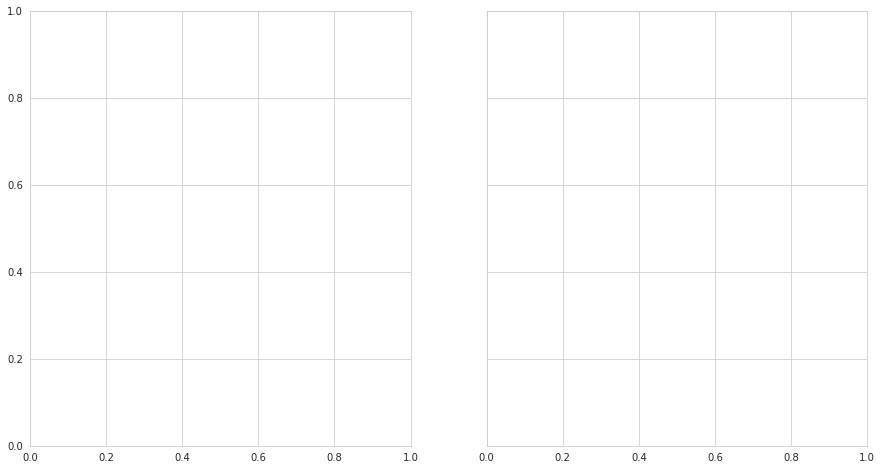

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8), sharey=True, sharex=True)
# Normalize the count so the area of the histogram is 1 and can be used with a common axis
b = sns.distplot(biden_citations['bias_score'], ax=ax1, kde=False, color="blue") # binwidth=0.2, ax=ax1)
ax1.set_title('Citation for pages with keyword "Joe Biden"', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Bias score', fontsize=15)
sns.distplot(donald_citations['bias_score'], ax=ax2, kde=False, color="blue") # binwidth=0.2, ax=ax2)
ax2.set_title('Citation for pages with keyword "Donald Trump"', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Bias score', fontsize=15)
b.set_ylabel('Count of citations', fontsize=15)
plt.tight_layout()
plt.savefig('count_citation_keyword.png', dpi=300)

In [293]:
donald_citations[donald_citations['bias_score'] > 1.3].groupby('tld').count()['URL']

tld
dailysignal              3
foxnews                260
heritage                 2
ijr                      4
israeltoday              2
lifenews                 1
nationalreview          22
pamelageller             1
pjmedia                  3
rushlimbaugh             3
spectator                4
thepoliticalinsider      1
townhall                 4
weeklystandard           4
Name: URL, dtype: int64

Looking at the individual pages for Trump and Biden, and look at the distribution of the citation.

But on the page level the distribution kind of looks the same.

In [294]:
print('Citations for page Joe Biden: {}'.format(citations_bias_features[citations_bias_features['page_title'] == 'Joe Biden'].shape[0]))
print('Citations for page Donald Trump: {}'.format(citations_bias_features[citations_bias_features['page_title'] == 'Donald Trump'].shape[0]))

Citations for page Joe Biden: 206
Citations for page Donald Trump: 422


In [6]:
joe_biden_page_citations = citations_bias_features[citations_bias_features['page_title'] == 'Joe Biden']
donald_trump_page_citations = citations_bias_features[citations_bias_features['page_title'] == 'Donald Trump']

In [12]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bottom_axes',
 '_clean_axis',
 '_col_var',
 '_col_wrap',
 '_colors',
 '_dropna',
 '_facet_color',
 '_facet_plot',
 '_finalize_grid',
 '_get_palette',
 '_hue_var',
 '_inner_axes',
 '_left_axes',
 '_legend',
 '_legend_data',
 '_legend_out',
 '_margin_titles',
 '_n_facets',
 '_ncol',
 '_not_bottom_axes',
 '_not_left_axes',
 '_not_na',
 '_nrow',
 '_row_var',
 '_update_legend_data',
 '_x_var',
 '_y_var',
 'add_legend',
 'ax',
 'axes',
 'col_names',
 'data',
 'despine',
 'facet_axis',
 'facet_data',
 'fig',
 'hue_kws',
 'hue_names',
 'map',
 'map_dataframe',
 'row_names',
 'savefig',
 'set',
 'set_axis_labels',
 'set_titles',

<Figure size 864x576 with 0 Axes>

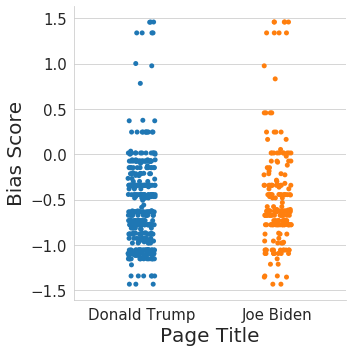

In [12]:
mask = (
    (citations_bias_features['page_title'] == 'Joe Biden') |
    (citations_bias_features['page_title'] == 'Donald Trump'))

plt.figure(figsize=(12, 8))
ax = sns.catplot(x="page_title", y="bias_score", data=citations_bias_features[mask], label='big')
ax.set_xlabels("Page Title",fontsize=20)
ax.set_ylabels("Bias Score", fontsize=20)
ax.set_xticklabels(fontsize=15)
ax.set_yticklabels(fontsize=15)
# ax.fig.suptitle("Distribution of bias over the specific titles")
plt.tight_layout()
plt.savefig('citations_trump_biden_dist.png', dpi=250)

In [29]:
titles_with_covid = citations_bias_features[
    citations_bias_features['page_title'].progress_apply(lambda x: 'COVID' in x)]

100%|██████████| 5678515/5678515 [00:05<00:00, 953918.31it/s] 


In [30]:
titles_with_covid.shape

(326, 20)

<Figure size 864x576 with 0 Axes>

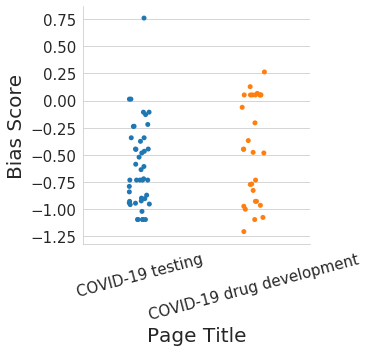

In [33]:
mask = (
    (citations_bias_features['page_title'] == 'COVID-19 testing') |
    (citations_bias_features['page_title'] == 'COVID-19 drug development'))

plt.figure(figsize=(12,8))
ax = sns.catplot(x="page_title", y="bias_score", data=citations_bias_features[mask])
plt.xticks(rotation=15)
ax.set_xlabels("Page Title",fontsize=20)
ax.set_ylabels("Bias Score", fontsize=20)
ax.set_xticklabels(fontsize=15)
ax.set_yticklabels(fontsize=15)
# ax.fig.suptitle("Distribution of bias over the specific titles")
plt.tight_layout()
plt.savefig('citations_covid_drug.png', dpi=250)

In [32]:
titles_with_climate = citations_bias_features[
    citations_bias_features['page_title'].progress_apply(lambda x: 'Climate' in x)]

100%|██████████| 5678515/5678515 [00:06<00:00, 932996.73it/s] 


In [33]:
titles_with_climate.shape

(1376, 20)

In [34]:
mitgation_citations = citations_bias_features[
    citations_bias_features['page_title'] == 'Climate change mitigation']
mitgation_citations[mitgation_citations['bias_score'] > 0.45]

,URL,tld,citations,Title,sub_domain,sections,type_of_citation,ID_list,id,r_id,r_parentid,page_title,page_id,ref_index,total_words,neighboring_words,neighboring_tags,bias_score,sub_dom,has_subdom
8531773,http://www.kiplinger.com/article/investing/T04...,kiplinger,{{cite web |url=http://www.kiplinger.com/artic...,5 Mutual Funds for Socially Responsible Investors,,Initial Section,cite web,None,2119179,954033027,954032900.0,Climate change mitigation,2119179,26065,30323,"[large, geographic, footprint, of, their, mult...","[JJ, JJ, NN, IN, PRP$, JJ, NNS, ., RB, JJ, VBG...",0.4845,,no


100%|██████████| 1809/1809 [00:00<00:00, 449789.31it/s]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<Figure size 1080x576 with 0 Axes>

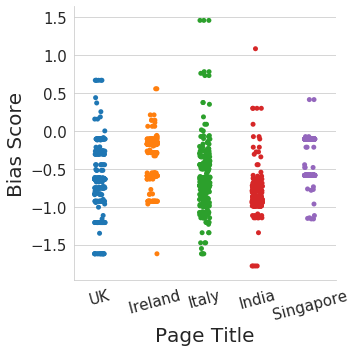

In [34]:
mask = (
    (citations_bias_features['page_title'] == '2020 coronavirus pandemic in the Republic of Ireland') |
    (citations_bias_features['page_title'] == '2020 coronavirus pandemic in India') | 
    (citations_bias_features['page_title'] == '2020 coronavirus pandemic in the United Kingdom') | 
    (citations_bias_features['page_title'] == '2020 coronavirus pandemic in Singapore') |
    (citations_bias_features['page_title'] == '2020 coronavirus pandemic in Italy')
)

citations_countries = citations_bias_features[mask]
citations_countries['page_title'] = citations_countries['page_title'].progress_apply(lambda x: x.replace(
    '2020 coronavirus pandemic in ', '').replace('the ', '').replace('Republic of', '').replace('United Kingdom', 'UK'))

plt.figure(figsize=(15, 8))
ax = sns.catplot(x="page_title", y="bias_score", data=citations_countries)
# ax.fig.suptitle("Distribution of bias over the specific titles")
ax.set_xlabels("Page Title",fontsize=20)
ax.set_ylabels("Bias Score", fontsize=20)
ax.set_xticklabels(fontsize=15)
ax.set_yticklabels(fontsize=15)
plt.xticks(rotation=15)

plt.tight_layout()
plt.savefig('citations_corona_timelines.png', dpi=250)

In [36]:
citations_countries[citations_countries['bias_score'] > 0.5][['Title', 'bias_score', 'tld', 'sub_dom', 'page_title']]

,Title,bias_score,tld,sub_dom,page_title
1138483,London Heathrow to close runway as it scales b...,0.6675,standard,,UK
1715858,Amitabh Bachchan deletes post on 'clapping vib...,1.0839,trib,,India
2008249,Who are the 1.5m vulnerable people self-isolat...,0.6675,standard,,UK
2655557,Dozens of travelers from Italy refused entry t...,0.7812,ynetnews,,Italy
3002880,Samaritan's Purse opens coronavirus field hosp...,1.4577,foxnews,,Italy
3362336,Coronavirus news LIVE: Number of UK patients h...,0.6675,standard,,UK
3738811,Cruise ship MSC Meraviglia turned away from tw...,1.4577,foxnews,,Italy
3856948,Galway 2020 - postponed and cancelled events,0.5556,advertiser,,Ireland
4607401,Health Ministry confirms second case of corona...,0.7596,jpost,,Italy
4860338,Endgame as Old Vic becomes first London theatr...,0.6675,standard,,UK


<Figure size 1080x576 with 0 Axes>

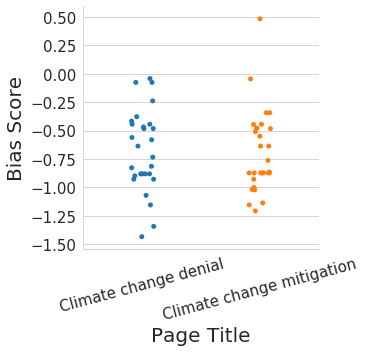

In [35]:
mask = (
    (citations_bias_features['page_title'] == 'Climate change mitigation') |
    (citations_bias_features['page_title'] == 'Climate change denial'))

plt.figure(figsize=(15,8))
ax = sns.catplot(x="page_title", y="bias_score", data=citations_bias_features[mask], label="big")
ax.set_xlabels("Page Title",fontsize=20)
ax.set_ylabels("Bias Score", fontsize=20)
ax.set_xticklabels(fontsize=15)
ax.set_yticklabels(fontsize=15)
# ax.fig.suptitle("Distribution of bias over the specific titles")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('citations_climate_change.png', dpi=250)

## Getting the categories for this dataset

This can be seen as to which categories are more prominent across which of the political bias scores

In [300]:
## Get all the category for each of the pages
# categories_dict = {}
# unique_pages = citations_bias_features['page_title'].unique()
# for p_no in tqdm(range(citations_bias_features['page_title'].nunique())):
#     p_title = unique_pages[p_no]
#     categories_dict[p_title] = [cat.name for cat in site.pages[p_title].categories()]

In [13]:
categories_dict = {}

In [14]:
## Reading the dump provided by DLAB to get all the category data out
## !bzip2 -d /dlabdata1/tmp/enwiki.labeled_article_items.json.bz2
data = ijson.parse(open('/dlabdata1/tmp/enwiki.labeled_article_items.json', 'r'), multiple_values=True)
current_article_pid = None

/home/harshdee/.local/lib/python3.7/site-packages/ijson/compat.py:48: DeprecationWarning: 
ijson works by reading bytes, but a string reader has been given instead. This
probably, but not necessarily, means a file-like object has been opened in text
mode ('t') rather than binary mode ('b').

An automatic conversion is being performed on the fly to continue, but on the
other hand this creates unnecessary encoding/decoding operations that decrease
the efficiency of the system. In the future this automatic conversion will be
removed, and users will receive errors instead of this warning. To avoid this
problem make sure file-like objects are opened in binary mode instead of text
mode.

  warnings.warn(_str_vs_bytes_warning, DeprecationWarning)


In [16]:
## Getting the categories from the drump for each of article PID
for prefix, event, value in data:
    if prefix == 'article_pid':
        current_article_pid = value
        categories_dict.setdefault(current_article_pid, [])
    if prefix == 'taxo_labels.item':
        categories_dict[current_article_pid].append(value)

In [17]:
citations_bias_features['categories'] = citations_bias_features['id'].progress_apply(
    lambda x: categories_dict.get(x, None))

100%|██████████| 5678515/5678515 [00:08<00:00, 680511.72it/s]


In [18]:
citations_categories_not_null = citations_bias_features[~citations_bias_features['categories'].isnull()]
print('The total number of citations with no categories: {}'.format(
    citations_bias_features.shape[0] - citations_categories_not_null.shape[0]))

The total number of citations with no categories: 353365


In [19]:
citations_categories_not_null['discretized_score'] = pd.cut(
    citations_categories_not_null['bias_score'],
    bins=[-2.0, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6, 2.0], 
    labels=['LIBR', '-4 (-1.6 to -1.2)', '-3 (-1.2 to -0.8)', '-2 (-0.8 to -0.4)', 
            '-1 (-0.4 to 0)', 'MODR', '1 (0.4 to 0.8)', '2 (0.8 to 1.2)', '3 (1.2 to 1.6)', 'CONS'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
aggregated_discretized_cat = citations_categories_not_null[['discretized_score', 'categories']].groupby(
    'discretized_score')['categories'].apply(list).reset_index()

In [21]:
aggregated_discretized_cat['count_categories'] = aggregated_discretized_cat['categories'].progress_apply(
    lambda x: Counter([item for sublist in x for item in sublist])
)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


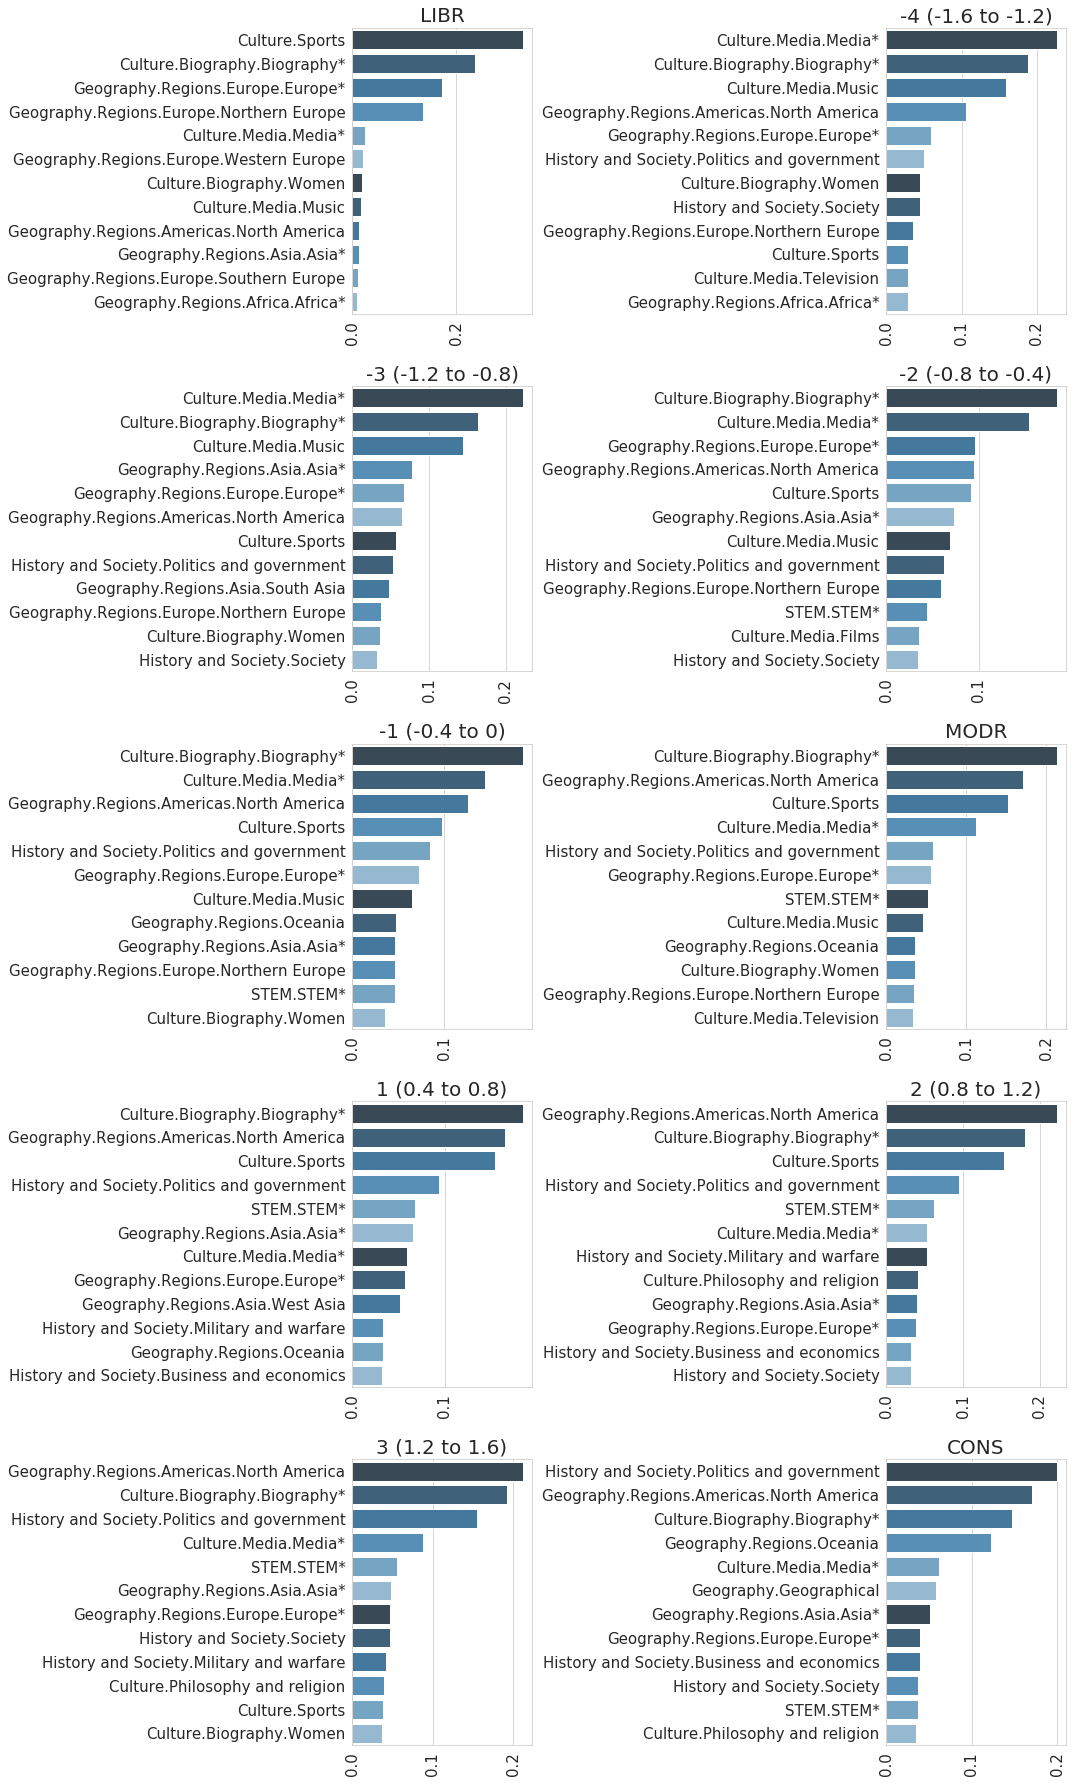

In [26]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
plt.subplots_adjust(wspace=0.5, hspace=2)
axes = axes.flatten()

discretized_labels = list(aggregated_discretized_cat['discretized_score'])

al = sns.color_palette("Blues_d")

for index in range(len(discretized_labels)):
    discretized_label_score = aggregated_discretized_cat[
        aggregated_discretized_cat['discretized_score'] == discretized_labels[index]][
        'count_categories'].values[0].most_common(12)
    subset_cat = pd.DataFrame(discretized_label_score)
    sum_subset_cat = subset_cat[1].sum()
    subset_cat[1] = subset_cat[1].apply(lambda x: float(x) / sum_subset_cat)
    ax = sns.barplot(x=1, y=0, data=subset_cat, ax=axes[index], palette=al)
    ax.set_title(discretized_labels[index], fontsize=20)
    ax.set_xlabel('', fontsize=20)
    ax.set_ylabel('', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    for item in ax.get_xticklabels():
        item.set_rotation(90)
        

plt.tight_layout()
fig.savefig('output_categories.png', dpi=300)

In [48]:
citations_with_NA = citations_bias_features[citations_bias_features['categories'].apply(
    lambda x: True if ((x is not None) and ('Geography.Regions.Americas.North America') in x) else False)]

citations_with_NEUR = citations_bias_features[citations_bias_features['categories'].apply(
    lambda x: True if ((x is not None) and ('Geography.Regions.Europe.Northern Europe') in x) else False)]

citations_with_NEUR.shape, citations_with_NA.shape

((532726, 21), (1121432, 21))

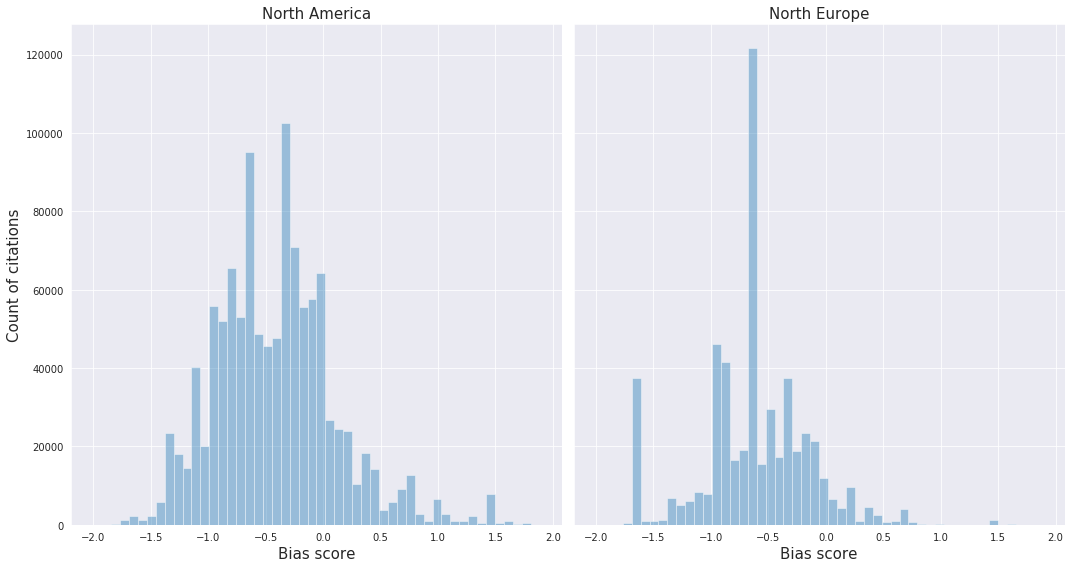

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8), sharey=True)
## Normalize the count so the area of the histogram is 1 and can be used with a common axis
b = sns.distplot(citations_with_NA['bias_score'], ax=ax1, kde=False)
ax1.set_title('North America', fontsize=15)
ax1.set_xlabel('Bias score', fontsize=15)
sns.distplot(citations_with_NEUR['bias_score'], ax=ax2, kde=False)
ax2.set_title('North Europe', fontsize=15)
ax2.set_xlabel('Bias score', fontsize=15)
b.set_ylabel('Count of citations', fontsize=15)
plt.tight_layout()
plt.savefig('categories_NA_EUR.png', dpi=300)

In [50]:
## Countings TLDs for North America categories and which ones are famous
citations_with_NA.groupby('tld').count().sort_values('Title', ascending=False)['Title'].head(10)

tld
mtv               90727
latimes           40168
cnn               33319
rollingstone      28148
usatoday          23827
billboard         22228
nhl               21185
chicagotribune    20684
npr               19180
bbc               18242
Name: Title, dtype: int64

In [51]:
## Number of citations with different categories which fall in high conservative content
(citations_with_NEUR[citations_with_NEUR['bias_score'] > 1.2].shape,
 citations_with_NA[citations_with_NA['bias_score'] > 1.2].shape)

((1473, 21), (13582, 21))

In [52]:
## News networks in North America category with a high bias score
citations_with_NA[
    citations_with_NA['bias_score'] > 1.2].groupby('tld').count().sort_values(
    'Title', ascending=False)['Title'].head(10)

tld
foxnews                    8425
nationalreview             1288
heritage                    824
amarillo                    510
weeklystandard              412
spectator                   273
townhall                    258
theamericanconservative     133
reporternews                131
rushlimbaugh                103
Name: Title, dtype: int64

In [53]:
## Spike in North Europe for liberal content between -0.6 and -0.7 for approx 120,000 items
mask = ((citations_with_NEUR['bias_score'] > -0.7) & (citations_with_NEUR['bias_score'] < -0.6))
citations_with_NEUR[mask].groupby('tld').count().sort_values('Title', ascending=False)['URL'].head(10)

tld
bbc            104116
skysports        5799
telegraph        4112
mtv              2390
metro            1864
latimes          1295
tv2               941
sydsvenskan       766
cnn               743
gp                555
Name: URL, dtype: int64

### Reliability of sources

- From a journalistic perspective: https://thetrustproject.org/ (nice 8 pointers for checking out the reliability)
- The Iffy.news Index of Unreliable Sources is a resource for researchers needing a database of untrustworthy online sources, based on factual-reporting ratings by Media Bias/Fact Check, the professional news/info website reviewer.
- Interesting EMNLP paper: https://github.com/ramybaly/News-Media-Reliability


- https://mediabiasfactcheck.com/methodology/ - Factual Reporting and understanding of the labels

In [41]:
## Remove globo and youtube and consider traditional news outlets
## Since reliability is only for news outlets and not for aggregators
citations_bias_features = citations_bias_features[~citations_bias_features['tld'].isin([
    'globo', 'youtube', 'flickr', 'google', 'uol', 'yahoo', 'mtv', 'billboard', 'officialcharts', 'fas', 'heritage',
    'facebook', 'nhl', 'minorleaguebaseball', 'soonersports', 'animenewsnetwork', 'discogs', 'motorsport', 'tamu'
])]

In [42]:
## Wrote a parser in Selenium to give the 
mbfc_data = pd.read_csv('/dlabdata1/harshdee/mbfc_data.csv')

In [43]:
mbfc_data.head()

,News Source,Bias,Reporting,Country,References
0,Syria News,Questionable Sources,Low,Unknown or Invalid Region,0
1,100% Fed up,Questionable Sources,Low,United States,"97,906"
2,10News.one,Questionable Sources,Low,United States,"2,011"
3,24 News,Questionable Sources,Low,United States,527
4,247 News Media,Questionable Sources,Very Low,Macedonia,213


In [44]:
mbfc_data.shape

(3203, 5)

In [45]:
## There are basically 6 main labels -- for reliability of news outlets
## Check the description in the link above for getting an outlook
print('Total number of news outlets: {}'.format(mbfc_data.shape[0]))
print('Set of reliable giveaway labels: {}'.format(mbfc_data['Reporting'].unique()))

Total number of news outlets: 3203
Set of reliable giveaway labels: ['Low' 'Very Low' 'Mixed' 'High' 'Mostly Factual' 'Very High']


In [46]:
mbfc_data['News Source'] = mbfc_data['News Source'].progress_apply(lambda x: x.lower())

100%|██████████| 3203/3203 [00:00<00:00, 409234.67it/s]


In [47]:
def find_the_closest_news(news_outlet):
    matches_with_perc = [
        (word, fuzz.token_set_ratio(word, news_outlet))
        for i, word in enumerate(mbfc_data['News Source'].unique())]
    max_percs = max([j for _, j in matches_with_perc])
    return [i for i, j in matches_with_perc if j == max_percs][0]

In [48]:
top_libr_news_outlets = citations_bias_features[citations_bias_features['bias_score'] < -0.5].groupby(
    'tld').count().reset_index().sort_values(['id'], ascending=False)

In [49]:
citations_bias_features[citations_bias_features['bias_score'] < -0.5].shape

(2650649, 21)

In [50]:
top_libr_news_outlets[['tld', 'URL']][:10]

,tld,URL
265,bbc,515260
1254,indiatimes,114246
2223,rollingstone,109353
1472,latimes,90192
1244,independent,84926
1176,hollywoodreporter,49789
1899,npr,48817
36,abc,46921
2583,thehindu,46226
1197,huffingtonpost,39342


In [51]:
map_mbfc_libr_tld = {}
for tld_ in list(top_libr_news_outlets['tld'][:10]):
    map_mbfc_libr_tld[tld_] = find_the_closest_news(tld_)

In [52]:
## Changes to names - handpicked if fuzzy search does not pick it up
map_mbfc_libr_tld['independent'] = 'the independent'
map_mbfc_libr_tld['npr'] = 'npr'

In [53]:
map_mbfc_libr_tld

{'bbc': 'bbc news',
 'indiatimes': 'india times',
 'rollingstone': 'rolling stone',
 'latimes': 'la times',
 'independent': 'the independent',
 'hollywoodreporter': 'hollywood reporter',
 'npr': 'npr',
 'abc': 'abc news australia',
 'thehindu': 'the hindu',
 'huffingtonpost': 'huffington post'}

In [66]:
top_ten_libr = top_libr_news_outlets[:10]
top_ten_libr['reliability'] = [
    mbfc_data[mbfc_data['News Source'] == i].values[0][2] for i in map_mbfc_libr_tld.values()]
sum_citations_libr = top_ten_libr['URL'].sum()
top_ten_libr['URL'] = top_ten_libr['URL'].apply(lambda x: (x / sum_citations_libr) * 100.0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [67]:
top_ten_libr

,tld,URL,citations,Title,sub_domain,sections,type_of_citation,ID_list,id,r_id,...,page_id,ref_index,total_words,neighboring_words,neighboring_tags,bias_score,sub_dom,has_subdom,categories,reliability
265,bbc,44.998044,515260,514954,515260,515260,515260,661,515260,515260,...,515260,515260,515260,515260,515260,515260,515260,515260,492758,High
1254,indiatimes,9.977189,114246,114092,114246,114246,114246,114,114246,114246,...,114246,114246,114246,114246,114246,114246,114246,114246,105472,Mixed
2223,rollingstone,9.549880,109353,109248,109353,109353,109353,1041,109353,109353,...,109353,109353,109353,109353,109353,109353,109353,109353,98124,High
1472,latimes,7.876535,90192,90109,90192,90192,90192,3527,90192,90192,...,90192,90192,90192,90192,90192,90192,90192,90192,86000,High
1244,independent,7.416652,84926,84860,84926,84926,84926,251,84926,84926,...,84926,84926,84926,84926,84926,84926,84926,84926,81094,Mixed
1176,hollywoodreporter,4.348111,49789,49758,49789,49789,49789,32,49789,49789,...,49789,49789,49789,49789,49789,49789,49789,49789,46985,High
1899,npr,4.263225,48817,48795,48817,48817,48817,31,48817,48817,...,48817,48817,48817,48817,48817,48817,48817,48817,45392,Very High
36,abc,4.097646,46921,46887,46921,46921,46921,21,46921,46921,...,46921,46921,46921,46921,46921,46921,46921,46921,45098,High
2583,thehindu,4.036951,46226,46171,46226,46226,46226,5193,46226,46226,...,46226,46226,46226,46226,46226,46226,46226,46226,43292,Mostly Factual
1197,huffingtonpost,3.435766,39342,39320,39342,39342,39342,2,39342,39342,...,39342,39342,39342,39342,39342,39342,39342,39342,37620,Mixed


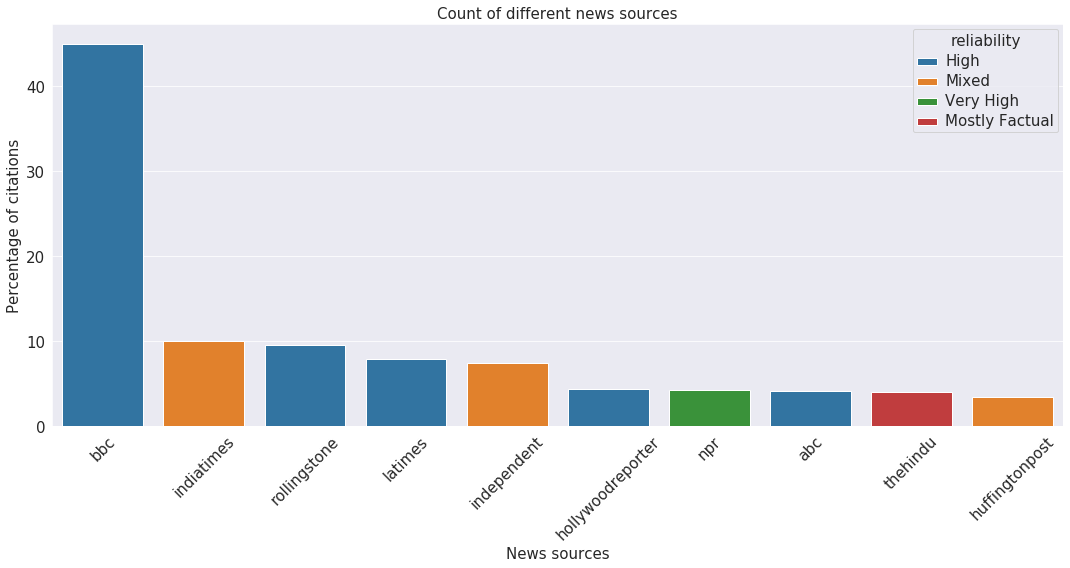

In [68]:
plt.figure(figsize=(15,8))
plt.ylabel('Count of citations', fontsize=15)
ax = sns.barplot(x="tld", y="URL", hue="reliability", data=top_ten_libr, dodge=False)
ax.set_title('Count of different news sources', fontsize=15)
plt.xlabel('News sources', fontsize=15)
plt.ylabel('Percentage of citations', fontsize=15)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.tight_layout()
plt.savefig('reliability_libr.png', dpi=300)

In [54]:
## Do not have any value for TAMU
top_cons_news_outlets = citations_bias_features[citations_bias_features['bias_score'] > 0.5].groupby(
    'tld').count().reset_index().sort_values(['id'], ascending=False)[:24]

In [55]:
map_mbfc_cons_tld = {}
map_mbfc_cons_tld['foxnews'] = 'fox news'
map_mbfc_cons_tld['jpost'] = 'the jerusalem report'
map_mbfc_cons_tld['standard'] = 'london evening standard'
map_mbfc_cons_tld['timesofisrael'] = 'times of israel'
map_mbfc_cons_tld['al'] = 'al com alabama news'
map_mbfc_cons_tld['washingtontimes'] = 'washington times'
map_mbfc_cons_tld['ynetnews'] = 'ynetnews'
map_mbfc_cons_tld['militarytimes'] = 'military times'
map_mbfc_cons_tld['tulsaworld'] = 'tulsa world'
map_mbfc_cons_tld['spectator'] = 'the spectator uk'
map_mbfc_cons_tld['christianpost'] = 'christian post'
map_mbfc_cons_tld['omaha'] = 'omaha world hearld'

In [56]:
reliability_cons = []
reliability_dict = {}
for i, j in map_mbfc_cons_tld.items():
    if j in ['times of israel', 'al com alabama news', 'ynetnews', 'omaha world hearld']:
        reliability_dict[i] = 'High'
    elif j == 'tulsa world':
        reliability_dict[i] = 'Low'
    elif j == 'washington times':
        reliability_dict[i] = 'Mixed'
    elif j == 'the spectator uk':
        reliability_dict[i] = 'Mostly Factual'
    else:
        reliability_dict[i] = mbfc_data[mbfc_data['News Source'] == j].values[0][2]

In [57]:
## Setting the reliability label for cons citations
cons_citations = citations_bias_features[citations_bias_features['bias_score'] > 0.5]
cons_citations['reliability'] = cons_citations['tld'].progress_apply(lambda x: reliability_dict.get(x, None))
selected_cons_citations = cons_citations[cons_citations['reliability'].notnull()]

100%|██████████| 137789/137789 [00:00<00:00, 745516.62it/s]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
## Checking percentage of citations per range for different reliability scores
RELIABILITY_CHECK = 'Mostly Factual'

In [59]:
selected_reliability = selected_cons_citations[
    selected_cons_citations['reliability'] == RELIABILITY_CHECK]['bias_score'].reset_index()
final_res = selected_reliability.groupby('bias_score').count().reset_index()
final_res['index'] = (final_res['index'] / selected_reliability.shape[0]) * 100.0
# selected_reliability = pd.cut(selected_reliability, bins=4).value_counts()
# final_res = selected_reliability.progress_apply(lambda x: (x / selected_reliability.sum()) * 100.0).reset_index()

In [60]:
final_res

,bias_score,index
0,1.4198,100.0


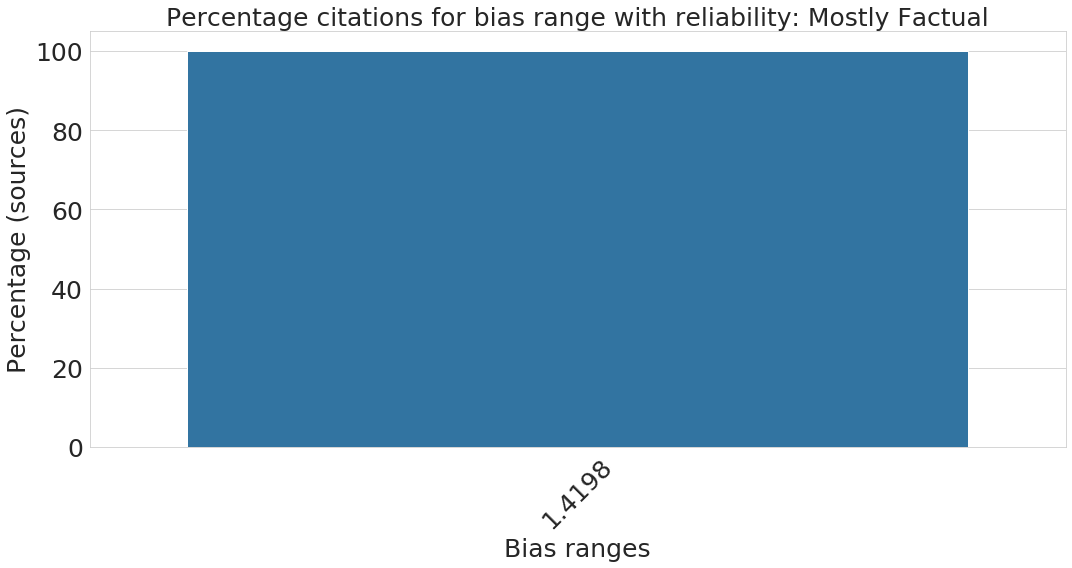

In [61]:
plt.figure(figsize=(15,8))
ax = sns.barplot(y="index", x="bias_score", data=final_res)
ax.set_title('Percentage citations for bias range with reliability: {}'.format(RELIABILITY_CHECK), fontsize=25)
plt.ylabel('Percentage (sources)', fontsize=25)
plt.xlabel('Bias ranges', fontsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('count_ranges_{}.png'.format(RELIABILITY_CHECK), dpi=300)

In [62]:
selected_cons_citations[selected_cons_citations['reliability'] == RELIABILITY_CHECK].groupby('tld').count().sort_values(
    'URL', ascending=False)

,URL,citations,Title,sub_domain,sections,type_of_citation,ID_list,id,r_id,r_parentid,...,page_id,ref_index,total_words,neighboring_words,neighboring_tags,bias_score,sub_dom,has_subdom,categories,reliability
tld,,,,,,,,,,,,,,,,,,,,,
spectator,2727,2727,2723,2727,2727,2727,8,2727,2727,2727,...,2727,2727,2727,2727,2727,2727,2727,2727,2580,2727


In [64]:
top_ten_cons

,tld,URL,citations,Title,sub_domain,sections,type_of_citation,ID_list,id,r_id,...,page_title,page_id,ref_index,total_words,neighboring_words,neighboring_tags,bias_score,sub_dom,has_subdom,categories
152,foxnews,16706,16706,16688,16706,16706,16706,5,16706,16706,...,16706,16706,16706,16706,16706,16706,16706,16706,16706,16002
232,jpost,9510,9510,9496,9510,9510,9510,3,9510,9510,...,9510,9510,9510,9510,9510,9510,9510,9510,9510,8980
395,standard,9019,9019,9011,9019,9019,9019,13,9019,9019,...,9019,9019,9019,9019,9019,9019,9019,9019,9019,8508
434,timesofisrael,6876,6876,6871,6876,6876,6876,1,6876,6876,...,6876,6876,6876,6876,6876,6876,6876,6876,6876,6322
14,al,5943,5943,5942,5943,5943,5943,0,5943,5943,...,5943,5943,5943,5943,5943,5943,5943,5943,5943,5676
469,washingtontimes,5421,5421,5419,5421,5421,5421,9,5421,5421,...,5421,5421,5421,5421,5421,5421,5421,5421,5421,5178
495,ynetnews,4500,4500,4495,4500,4500,4500,0,4500,4500,...,4500,4500,4500,4500,4500,4500,4500,4500,4500,4324
288,militarytimes,3571,3571,3567,3571,3571,3571,1,3571,3571,...,3571,3571,3571,3571,3571,3571,3571,3571,3571,3349
446,tulsaworld,2823,2823,2818,2823,2823,2823,2,2823,2823,...,2823,2823,2823,2823,2823,2823,2823,2823,2823,2702
392,spectator,2727,2727,2723,2727,2727,2727,8,2727,2727,...,2727,2727,2727,2727,2727,2727,2727,2727,2727,2580


In [63]:
top_ten_cons = top_cons_news_outlets[:10]
top_ten_cons['reliability'] = reliability_cons
sum_citations_cons = top_ten_cons['URL'].sum()
top_ten_cons['URL'] = top_ten_cons['URL'].apply(lambda x: (x / sum_citations_cons) * 100.0)

ValueError: Length of values does not match length of index

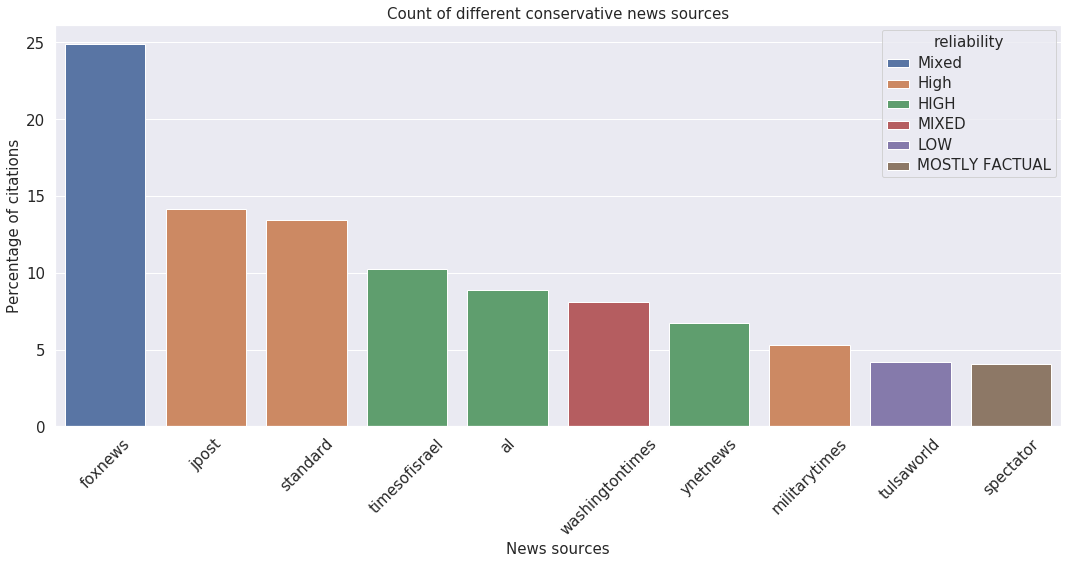

In [225]:
plt.figure(figsize=(15,8))
plt.ylabel('Count of citations', fontsize=15)
ax = sns.barplot(x="tld", y="URL", hue="reliability", data=top_ten_cons, dodge=False)
ax.set_title('Count of different conservative news sources', fontsize=15)
plt.xlabel('News sources', fontsize=15)
plt.ylabel('Percentage of citations', fontsize=15)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.tight_layout()
plt.savefig('reliability_cons.png', dpi=300)